
# Diagonal-Prior MAP: *Bad Pairing* Is a Saddle — First-Order Escape Experiment

This notebook reproduces a simple, robust experiment showing that, for the profiled MAP objective with a **diagonal** prior precision on the latent factors,
any stationary point that **mis-matches** eigenvalues to prior precisions (“bad pairing”) behaves as a **strict saddle**: first-order methods initialized nearby escape it.

Here is the notation used:

- Data covariance: $S = Y^\top Y \in \mathbb{R}^{p\times p}$, symmetric, with eigenpairs $(\lambda_1,g_1),\ldots,(\lambda_p,g_p)$ and $\lambda_1\ge\cdots\ge\lambda_p$.
- Rank: $R$. The matrix $V \in \mathbb{R}^{p\times R}$ has orthonormal columns (Stiefel constraint $V^\top V = I_R$).
- Diagonal prior precision on $U$: $\Delta = \mathrm{diag}(d_1,\ldots,d_R)$, entries **attached to the column slots** of $V$.
- Convenient weights: $w_k := \frac{1}{1 + d_k}$ (larger $w_k$ means smaller prior precision $d_k$).



## Profiled loss (on the Stiefel)

After substituting the optimal $U^\star(V)$, the profiled negative log-posterior is
$$
L(V) = \mathrm{tr}(S) + R - \mathrm{tr}\!\big( V^\top S\, V \,(I + \Delta)^{-1} \big), \qquad V^\top V = I_R.
$$
With $W := (I+\Delta)^{-1} = \mathrm{diag}(w_1,\ldots,w_R)$, this becomes
$$
L(V) = \mathrm{tr}(S) + R - \sum_{k=1}^R w_k\, \langle v_k, S v_k \rangle,
$$
so **each column contributes independently**: $c_k(v_k) = \big(- w_k\,\langle v_k,Sv_k\rangle\big)$.

At a stationary point, columns are eigenvectors of $S$: $v_k = g_{i_k}$ for some index set $I=\{i_1,\ldots,i_R\}$.


## “Bad pairing” (definition)

Fix a subset $I$ (e.g. the top $R$ eigenvectors). A **pairing** is the assignment of the $R$ eigenvalues $\{\lambda_{i_k}\}$
to the $R$ column slots (and thus to $\{d_k\}$ or $\{w_k\}$).

- **Good pairing:** match larger $\lambda$ with larger $w$ (equivalently, smaller $d$); i.e. sort $\{\lambda_{i_k}\}$ in descending order and $\{d_k\}$ in ascending order and match indexwise (rearrangement inequality).
- **Bad pairing:** there exists $i,j$ with $\lambda_{i_i}>\lambda_{i_j}$ but $d_i>d_j$ (equivalently $w_i<w_j$).

The directional second derivative of $L$ along the feasible 2D rotation that mixes $v_i$ and $v_j$ is
$$
L''(0) = -4\,(\lambda_{i_i}-\lambda_{i_j})\,(w_i-w_j).
$$
Thus a bad pairing has $L''(0)<0$ (strictly negative curvature).


## What we test here

We build a **bad-pairing** stationary point and run a simple **projected gradient descent** (first-order) starting from many tiny perturbations around it.
If the iterates consistently **move away** (loss drops and iterates approach the correctly paired solution), this is strong evidence of a **strict saddle**.


In [16]:

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

def make_S(p, eigvals):
    """Return S with the given spectrum and an orthogonal eigenbasis G (columns)."""
    Q, _ = np.linalg.qr(np.random.randn(p, p))
    return Q @ np.diag(eigvals) @ Q.T, Q  # S, G

def profiled_loss(S, V, d):
    """Profiled loss for diagonal Δ with entries d (shape (R,)). V must have orthonormal columns."""
    w = 1.0 / (1.0 + d)
    W = np.diag(w)
    return 0.5*np.trace(S) + 0.5*V.shape[1] - 0.5*np.trace(V.T @ S @ V @ W)

def procrustes(U, V):
    """Distance between column spaces (0 => same subspace)."""
    M = U.T @ V
    U1, _, V1 = np.linalg.svd(M, full_matrices=False)
    return np.linalg.norm(np.eye(M.shape[0]) - U1 @ V1)

def riemannian_grad(S, V, d):
    """Riemannian gradient of the profiled loss on the Stiefel."""
    w = 1.0 / (1.0 + d)
    W = np.diag(w)
    G = - S @ V @ W                      # Euclidean gradient of -0.5 tr(V^T S V W) up to constant
    sym = 0.5 * (V.T @ G + (V.T @ G).T)  # symmetrize
    return G - V @ sym                   # projection to tangent space

def reorth(V):
    Q, _ = np.linalg.qr(V)
    return Q



## Construct a synthetic problem

We choose a spectrum with clear gaps and a **non-isotropic** diagonal prior.


In [12]:

# Dimensions and spectrum
p = 30
R = 5
lambdas = np.array([12, 11, 10, 8, 7, 6, 4.5, 3.5, 2.8, 2.0] + [1.0]*(p-10))
S, G = make_S(p, lambdas)

# Diagonal prior (unsorted and non-equal)
d = np.array([2.5, 0.1, 1.8, 0.6, 3.2])   # Δ = diag(d1,...,dR)

# Convenience
I_top = list(range(R))             # indices of top-R eigenvalues
w = 1.0 / (1.0 + d)                # weights
w, lambdas[I_top]


(array([0.28571429, 0.90909091, 0.35714286, 0.625     , 0.23809524]),
 array([12., 11., 10.,  8.,  7.]))


## Build a good pairing and a bad pairing (both are stationary)

- **Good pairing:** match larger $\lambda$ (within the chosen subset) to larger $w$ (smaller $d$).  
- **Bad pairing:** reverse that matching to enforce inversions.

Both \(V\)'s are formed from eigenvectors of \(S\), so each is a stationary point.


In [13]:

# Good pairing
order_w_desc = np.argsort(-w)          # slots in descending w
V_good = np.zeros((p, R))
for slot, col in enumerate(order_w_desc):
    V_good[:, col] = G[:, I_top[slot]]
V_good = reorth(V_good)

# Bad pairing (reverse the matching)
order_w_asc = np.argsort(w)
V_bad = np.zeros((p, R))
for slot, col in enumerate(order_w_asc):
    V_bad[:, col] = G[:, I_top[slot]]
V_bad = reorth(V_bad)

L_good = profiled_loss(S, V_good, d)
L_bad  = profiled_loss(S, V_bad,  d)

print("Loss at good pairing :", L_good)
print("Loss at bad pairing  :", L_bad, " (higher => suboptimal)")
print("Procrustes distance (V_good vs V_bad):", procrustes(V_good, V_bad))


Loss at good pairing : 33.24604978354979
Loss at bad pairing  : 35.43246753246754  (higher => suboptimal)
Procrustes distance (V_good vs V_bad): 2.8284271247461903



## First-order method from near the bad pairing

We run projected gradient descent (Riemannian gradient step + QR re-orthonormalization) starting from many tiny perturbations around $V_{\text{bad}}$.
We record whether the run **escapes** (loss drops and the iterate moves closer to $V_{\text{good}}$).


Trials that escaped the bad pairing basin: 182/200


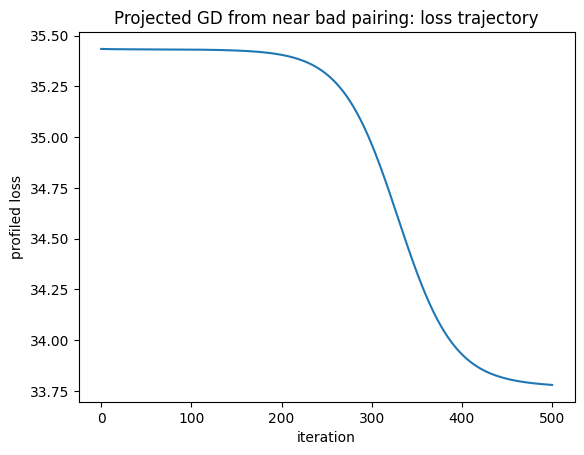

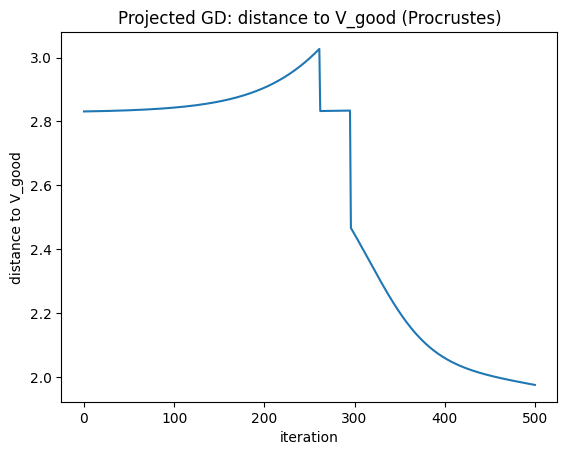

In [14]:

def run_pgd(start_V, S, d, steps=500, eta=0.01, noise_scale=3e-3):
    V = start_V.copy()
    V = reorth(V + noise_scale * np.random.randn(*V.shape))  # small tangent perturbation
    losses = [profiled_loss(S, V, d)]
    d_to_good = [procrustes(V, V_good)]
    for _ in range(steps):
        grad = riemannian_grad(S, V, d)
        V = reorth(V - eta * grad)
        losses.append(profiled_loss(S, V, d))
        d_to_good.append(procrustes(V, V_good))
    return np.array(losses), np.array(d_to_good), V

trials = 200
escaped = 0
histories = []
for _ in range(trials):
    losses, dists, Vend = run_pgd(V_bad, S, d)
    escaped_flag = (losses[-1] < losses[0] - 1e-6) and (dists[-1] < dists[0] - 1e-4)
    escaped += int(escaped_flag)
    histories.append((losses, dists))

print(f"Trials that escaped the bad pairing basin: {escaped}/{trials}")

# Plot a representative trial
rep = 0
for k in range(trials):
    if histories[k][0][-1] < histories[k][0][0]:
        rep = k
        break

losses_rep, dists_rep = histories[rep]

plt.figure()
plt.plot(losses_rep)
plt.title("Projected GD from near bad pairing: loss trajectory")
plt.xlabel("iteration")
plt.ylabel("profiled loss")
plt.show()

plt.figure()
plt.plot(dists_rep)
plt.title("Projected GD: distance to V_good (Procrustes)")
plt.xlabel("iteration")
plt.ylabel("distance to V_good")
plt.show()



## Optional: finite-difference curvature along a swap direction

To directly connect with the second-derivative test, consider mixing two columns $i$ and $j$ inside the plane spanned by their eigenvectors.
For small $\varepsilon$,
$$
L''(0) \approx \frac{L(+\varepsilon) - 2L(0) + L(-\varepsilon)}{\varepsilon^2}.
$$
For a bad pairing, theory predicts
$$
L''(0) = -\,(\lambda_{i} - \lambda_{j})\,\big(w_i-w_j\big) \;<\; 0.
$$


In [15]:

# Choose two columns with an inversion: larger λ paired with smaller w (bad)
# We'll use slot indices based on orderings above.
i = order_w_asc[0]   # column with smallest w (largest d)
j = order_w_asc[-1]  # column with largest w (smallest d)

# Build a 2D rotation in span{g_a, g_b} that mixes the i-th and j-th columns
# Identify which eigenvectors currently occupy those columns in V_bad:
eig_idx_i = I_top[0]  # by construction: slot '0' carries the largest λ in V_bad assignment loop
eig_idx_j = I_top[-1] # and slot 'R-1' carries the smallest among the top-R

def V_theta(theta):
    Vi =  np.cos(theta)*G[:, eig_idx_i] + np.sin(theta)*G[:, eig_idx_j]
    Vj = -np.sin(theta)*G[:, eig_idx_i] + np.cos(theta)*G[:, eig_idx_j]
    V = V_bad.copy()
    V[:, i] = Vi
    V[:, j] = Vj
    V, _ = np.linalg.qr(V)
    return V

eps = 1e-5
L0 = profiled_loss(S, V_theta(0.0), d)
Lp = profiled_loss(S, V_theta(+eps), d)
Lm = profiled_loss(S, V_theta(-eps), d)
curv = (Lp - 2*L0 + Lm) / (eps**2)
print("Approximate L''(0) along swap direction:", curv)


Approximate L''(0) along swap direction: -3.3549696354384646
